In [24]:
import serial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz , argrelextrema , spectrogram , welch
import biosppy
import biosppy.signals.eda as eda
import neurokit2 as nk
import ledapy
from numpy.lib.stride_tricks import as_strided
import librosa

In [3]:
"""
  Get data from an Excel file
"""

def Get_dataFromExcel(a_file_path, a_column_name=None):
    try:
        # Read the Excel file
        l_df = pd.read_csv(a_file_path)
        
        # Extract the specified column
        if( a_column_name == None):
            l_column_temp = l_df.values.tolist()
            l_column_data = [item for sublist in l_column_temp for item in sublist]

        else:    
            l_column_data = l_df[a_column_name].tolist()
        
        return l_column_data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None



In [4]:
"""
   Read a file
"""

def Get_dataFromTextFile( a_file_name ):
    # Open the file
    l_file_path = a_file_name  # Provide the path to your text file
    l_x = []

    with open(l_file_path, 'r') as file:
        # Read each line in the file
        for line in file:
            # Remove leading/trailing whitespaces and split if there are commas
            line_data = line.strip().split(',')

            # Convert each non-empty item in the line to a float and add to the data list
            for item in line_data:
                if item.strip():  # Check if the item is not an empty string
                    l_x.append(float(item))
    return l_x    

In [15]:
"""
Min_Max normalization
Perform Min-Max Normalization on a list of data.

Parameters:
- data (list): The input list of numerical values.

Returns:
- normalized_data (list): The list of normalized values.
"""
def min_max_normalization(a_data):

#     l_min_val = min(a_data)
#     l_max_val = max(a_data)

#     l_normalized_data = [(l_x - l_min_val) / (l_max_val - l_min_val) for l_x in a_data]
    a_data = [x / 100 for x in a_data]

    return a_data

In [5]:
"""
The function take the signal and return the filtered signal
""" 
def apply_low_pass_filter_on_a_signal( order , normalized_cutoff , signal  ):
    fir_coefficients = firwin( order + 1, normalized_cutoff , window='hamming' ) # It return the FIR filter coefficients (bk)
    filtered_signal = np.convolve( signal , fir_coefficients, mode='same')  # 'same' to keep the output length the same
    return filtered_signal   



In [28]:
"""
                Not good to Extract onset and offset, so we didn't use it
                
  Make preprocessing       : Applaying FIR Low pass filter of order 50 at cutoff 1.5/Fs
                             Make Min_Max Normalization to the signal
  Extract Phasic and tonic : Using cvxEDA method from neurokit2 package                     
"""
def GSR_preprocessingAndExtractPhasicAndTonic( a_signal , a_plot=True ):
    
    a_signal = min_max_normalization(a_signal) #First make normalization to the signal
    a_signal = apply_low_pass_filter_on_a_signal( 50 , 1.5/Fs , a_signal ) # Make a Low pass filter



    l_eda_tonic_phasic = nk.eda_phasic( a_signal , sampling_rate=Fs , method="cvxEDA"  )


    l_eda_phasic = l_eda_tonic_phasic['EDA_Phasic'].tolist()
    l_eda_tonic = l_eda_tonic_phasic['EDA_Tonic'].tolist()
    
    
    if( a_plot == True ):
        plt.subplot(3,1,1)
        plt.plot(a_signal, 'b')
        plt.subplot(3,1,1)
        plt.plot( l_eda_tonic , 'r' )
        plt.subplot(3,1,3)
        plt.plot( l_eda_phasic )
        plt.subplot(3,1,3)
        plt.plot( [0.01]*len(a_signal) )
        
    return l_eda_tonic , l_eda_phasic   


# Fs = 10
# x = Get_dataFromTextFile('serial_data_1.txt')    
# llvll,ggg = GSR_preprocessingAndExtractPhasicAndTonic(x,True)


In [12]:
"""
                      GSR_ExtractPhasicTonic_OnsetAndOffset
                      
  Make preprocessing       : Applaying FIR Low pass filter of order 50 at cutoff 1/Fs
                             Make Min_Max Normalization to the signal
 Extract Phasic and tonic  : Using neurokit method
 Extract onset and offset  : from pahsic componat of signal using threshold 0.01 of onset
                             and 0 of offset
 Extract peaks             : from cleaned data, it will extract peaks between each couple onset and offset                           
 return                    : It returns phasic, tonic, onset_offset couple and peaks
                            
"""
def GSR_ExtractPhasicTonic_OnsetAndOffset_Peaks( a_gsr_sig , a_plot=True ):
    
    l_sig =  apply_low_pass_filter_on_a_signal( 50 , 1/Fs , a_gsr_sig ) # Make a Low pass filter
    l_sig = min_max_normalization(l_sig) # Make Normalization

    # --- Get phasic and tonic componants ---
    l_process_sig , l_process_info = nk.eda_process(  l_sig , sampling_rate=Fs , method='neurokit' )
    l_tonic  = l_process_sig['EDA_Tonic'].tolist()   # Get tonic  componant and change it to a list
    l_phasic = l_process_sig['EDA_Phasic'].tolist()  # Get phasic componant and change it to a list
    
    # cvxEDA method gives a phasic compnant from 0 to 1, no offset in it, so we didn't use it
#     l_eda_tonic_phasic = nk.eda_phasic( l_sig , sampling_rate=Fs , method="cvxEDA"  )
#     l_phasic = l_eda_tonic_phasic['EDA_Phasic'].tolist()
#     l_tonic = l_eda_tonic_phasic['EDA_Tonic'].tolist()
    
    l_phasic = l_phasic[0:] # Slice phasic componant
    l_sig = l_sig[0:]

    # --- Calculate onsets and offsets ---
    l_onset_threshold = 0.01
    l_offset_threshold=0

    # Initialize onset and offset array
    l_onset  = np.zeros( len(l_phasic) )
    l_offset = np.zeros( len(l_phasic) )

    # Onset
    for i in range( len(l_phasic) ): # Get all points that is larger than onset threshold 
        if( l_phasic[i] > l_onset_threshold ):
            l_onset[i] = i
        else:
            l_onset[i] = 0

    # Offset
    for i in range( len(l_phasic) ): # Get all points that is smaller than offset threshold 
        if( l_phasic[i] <= l_offset_threshold ):
            l_offset[i] = i
        else:
            l_offset[i] = 0

    # The next step is to couple onset and offset with each other
    l_index = 0
    l_token = 1
    l_len = max( len(l_offset) , len(l_onset) )


    l_onset_offset_couple = []  # An array that will save the onset and offset couples

    for i in range( l_len-1 ):
        if( l_token == 1 ): 
            while( l_index < len(l_onset) and l_onset[l_index] == 0 ):
                l_index = l_index + 1
    
            # A start of an onset
            l_onset_index = l_index 
            l_token = 0

        if( l_token == 0 ):
            while( l_index < len(l_offset) and l_offset[l_index] == 0 ):
                l_index = l_index + 1
  
            # couple offset with it's onset
            l_offset_index = l_index
            l_token = 1
            # Cheack if it reaches end of list
            if( l_index >= l_len-1 ):
                break  
            else :
                 l_onset_offset_couple.append( [l_onset_index,l_offset_index] ) # append couple
    
    
   
            
    # Separate onset and offset points from each other to draw them
    l_draw_onset = []
    for i in range( len(l_onset_offset_couple) ):
        l_draw_onset.append( l_onset_offset_couple[i][0] )
        
    l_draw_offset = []
    for i in range( len(l_onset_offset_couple) ):
        l_draw_offset.append( l_onset_offset_couple[i][1] )    

    # X_axis of the onset and offsets    
    l_onset_x_axis  = [l_onset_threshold]*len(l_draw_offset) 
    l_offset_x_axis = [l_offset_threshold]*len(l_draw_offset)
        

    # --- Find peaks between each onset and offset ---
    l_interval = [] # Will contain values of samples between onset and offset
    l_peaks = [] # Will contains the peaks for each onset-offset pair
    for i in range( len(l_onset_offset_couple ) ):
        l_j=0
        l_temp = l_onset_offset_couple[i][0] # Get the index of onset point

        while( l_temp < l_onset_offset_couple[i][1] ): # Loop untill reaches the corresponding offset value
            l_interval.append( l_sig[ l_temp ] ) # append the raw signal value which is between onset and offset
            l_temp+=1
        # At this point we reaches the end of onset-offset interval
        l_max_value = max(l_interval) # peak value
        l_peaks.append( [  l_temp-len(l_interval)+l_interval.index(l_max_value) , l_max_value ] ) # append the peaks index and peak value
        l_interval.clear() # Clear the interval list
        
    # Separate index of peak points from peak value in two arrays
    l_draw_peak_index = []
    l_draw_peak_value = []
    for i in range( len(l_peaks) ):
        l_draw_peak_index.append( l_peaks[i][0] ) 
        l_draw_peak_value.append( l_peaks[i][1] ) 
        
    # Draw a histogram
    l_timeForEachSample = 100
    l_draw_histogram = np.zeros( int( len(l_phasic)/(Fs*l_timeForEachSample) ) + 1 )
    for i in range( len(l_draw_peak_index) ):
        l_his_index = int( l_draw_peak_index[i]/(Fs*l_timeForEachSample) ) # Get interval of each sample
        l_draw_histogram[ l_his_index ] += 1 # increment 
        
    # Plot
    if( a_plot == True ):
        plt.subplot(3,1,1)
        plt.title('phasic')
        plt.plot(l_phasic )
        plt.scatter( l_draw_onset , l_onset_x_axis , c='r' , label='onset'   )   # Draw onsets
        plt.scatter( l_draw_offset , l_offset_x_axis , c='g' , label='offset'   ) # Draw offsets
        plt.grid()
        plt.subplot(3,1,2)
        plt.title('Raw data')
        plt.plot(l_sig , label='cleaned signal')
        plt.scatter( l_draw_peak_index , l_draw_peak_value ,c='#FF5733' , marker='x' ) 
        plt.grid()
        plt.subplot(3,1,3 )
        plt.bar( np.arange(0,len(l_draw_histogram) ) , l_draw_histogram)
        plt.grid()

        
    return l_phasic , l_draw_histogram , l_tonic , l_onset_offset_couple , l_peaks     
    
    
    
# Fs = 10    
# x = Get_dataFromTextFile('serial_data_1.txt')    
# x= kkkk

# f , g , _ , _ , _ = GSR_ExtractPhasicTonic_OnsetAndOffset_Peaks(x)    
# g

In [6]:
"""
   This function takes the phasic, onset and peaks and plot them
"""
def Plot_Phasic_with_onset_and_peaks( a_phasic , a_onset , a_peak ):
    l_ts = np.linspace(0, (len(a_phasic)-1)/16,len(a_phasic),endpoint=False)
    plt.plot(l_ts,a_phasic , label='Signal 1')
    plt.scatter(l_ts[a_peak],a_phasic[a_peak],c='r',s=10 , label='Signal 1')
    plt.scatter(l_ts[a_onset],a_phasic[a_onset],c='y',s=10 , label='Signal 1')

def Plot_orign_with_onset_and_peaks( a_orign , a_tonic , a_onset , a_peak ):
    l_ts = np.linspace(0, (len(a_orign)-1)/16,len(a_orign),endpoint=False)
    plt.plot(l_ts,a_orign,c='b')
    plt.plot(l_ts,a_tonic,c='g')
    plt.scatter(l_ts[a_peak] ,a_orign[a_peak],c='r',s=20)
    plt.scatter(l_ts[a_onset] , a_orign[a_onset],c='y',s=10)
    

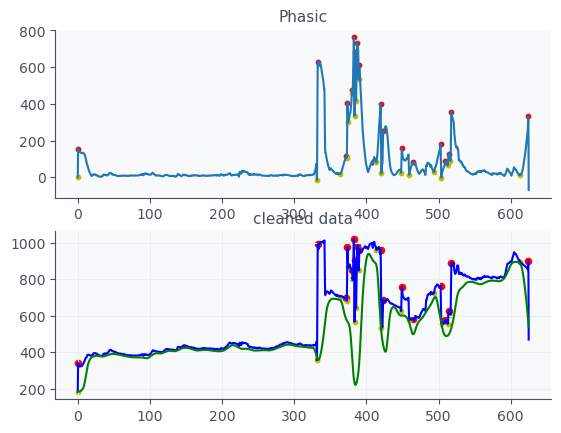

[386.0, 386.0, 354.0, 308.0, 288.0, 278.0, 281.0, 288.0, 314.0, 374.0]

In [41]:
"""
   This function is used to plot data from Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks functio
"""

def Ledapy_plot( a_orign , a_phasic , a_tonic , a_onset , a_peak):
    plt.subplot(2,1,1)
    plt.title('Phasic')
    plt.grid()
    Plot_Phasic_with_onset_and_peaks( a_phasic , a_onset , a_peak )
    
    plt.subplot(2,1,2)
    plt.grid()
    plt.title('cleaned data')
    Plot_orign_with_onset_and_peaks(  a_orign , a_tonic , a_onset , a_peak )
    plt.grid()
    plt.show()
    plt.close()
    
    
"""
                      Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime
                      
  Make preprocessing       : Applaying FIR Low pass filter of order 50 at cutoff 1.5/Fs
                             Make Min_Max Normalization to the signal
 Extract Phasic and tonic  : Using ledapy method
 Extract onset and offset  : from pahsic componat of signal using threshold 0.1 
 
 Extract peaks             : from cleaned data, it will extract peaks                      
 return                    : It returns cleaned signal , phasic , tonic , onsets , peaks, raise_time
                            
"""
def Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( a_signal , a_min_amplitude , a_plot=True ):                
    l_scrs, l_amps, l_ZC, l_pks = [], [], [], []
    a_signal = apply_low_pass_filter_on_a_signal( 50 , 1/Fs , a_signal ) # Make a Low pass filter
    
    l_phasicData  = ledapy.runner.getResult( a_signal ,  'phasicdata' , sampling_rate =Fs , downsample=1 )
    l_pahsicDriver = ledapy.runner.getResult( a_signal , 'phasicdriver' , sampling_rate =Fs , downsample=1 )
    l_tonicData = a_signal - l_phasicData


    # Find zero crossings
    l_zeros = argrelextrema(l_phasicData,np.less)[0]

    l_zeros = np.insert(l_zeros,0,0) # Insert zereo at index zero
    l_zeros = np.insert(l_zeros,len(l_zeros) , len(l_phasicData)-1) # insert the last index in the array at end


    for i in range(0, len(l_zeros) - 1, 1):
        l_scrs += [ l_phasicData[l_zeros[i]:l_zeros[i + 1]+1] ]
        l_aux = l_scrs[-1].max()
        if l_aux > l_phasicData[l_zeros[i]] and l_aux > l_phasicData[l_zeros[i+1]]:
            l_amps += [l_aux-l_phasicData[l_zeros[i]]]
            l_ZC += [l_zeros[i]]
            l_ZC += [l_zeros[i + 1]]
            l_pks += [l_zeros[i] + np.argmax(l_phasicData[l_zeros[i]:l_zeros[i + 1]])]
        elif l_aux == l_phasicData[l_zeros[-1]]:
            l_amps += [l_aux-l_phasicData[l_zeros[-2]]]
            l_ZC += [l_zeros[-2]]
            l_ZC += [l_zeros[-1]]
            l_pks += [l_zeros[-1]]
    if l_amps == []:
        l_ZC += [np.argmin(l_phasicData)]
        l_amps += [np.max(l_phasicData[l_ZC[0]:])-l_phasicData[l_ZC[0]]]
        l_pks += [np.argmax(l_phasicData[l_ZC[0]:])]

    # Find the maximum length of arrays in the list
    l_max_length = max(len(l_scrs) for l_scrs in l_scrs)

    # Pad shorter arrays with zeros to make them the same length
    l_padded_scrs = [np.pad(l_scrs, (0, l_max_length - len(l_scrs)), 'constant') for l_scrs in l_scrs ]

    l_scrs = np.array(l_padded_scrs)
    l_amps = np.array(l_amps)
    l_ZC = np.array(l_ZC)
    l_pks = np.array(l_pks)
    l_onsets = l_ZC[::2]
    l_thr = a_min_amplitude * np.max(l_amps)
    l_arglow = np.where(l_amps<l_thr)
    l_amps = np.delete(l_amps,l_arglow)
    l_pks = np.delete(l_pks,l_arglow)
    l_onsets = np.delete(l_onsets,l_arglow)

    l_risingtimes = l_pks-l_onsets
    l_risingtimes = l_risingtimes/16

    l_pks = l_pks[l_risingtimes > 0.1]
    l_onsets = l_onsets[l_risingtimes > 0.1]
    l_amps = l_amps[l_risingtimes > 0.1]
    
    # Plot
    if( a_plot == True ):
        Ledapy_plot( a_signal , l_phasicData, l_tonicData , l_onsets , l_pks )

        
        
    l_rise_time = l_pks - l_onsets
    return  a_signal , l_phasicData , l_tonicData , l_onsets , l_pks , l_rise_time


Fs = 10    
x =  Get_dataFromTextFile('Studing_Cypersecyrity_lec3_part2.txt') 

clean_sig , ph , ton , onsets , ppk , raise_time = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime(  np.array(x) , 0.1 )

x[0:10]

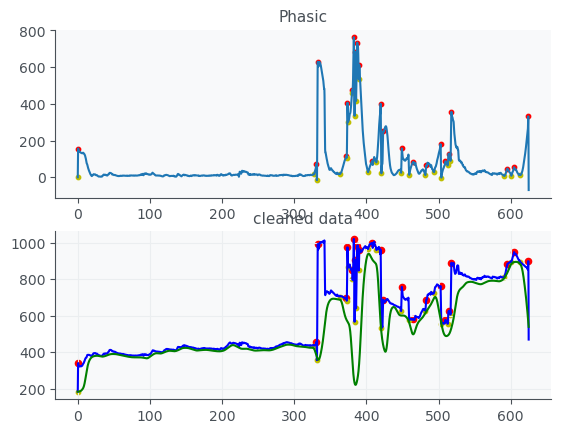

23


In [42]:
Fs = 10    
x =  Get_dataFromTextFile('Studing_Cypersecyrity_lec3_part2.txt') 
# plt.plot(x)
clean_sig , ph , ton , onsets , ppk , raise_time = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime(  np.array(x) , 0.05)

print(len(ppk ))
# print(onsets)
# ppk

1

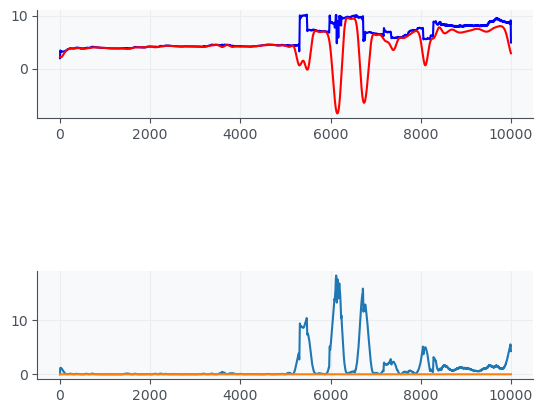

In [43]:
Fs = 10    
x =  Get_dataFromTextFile('Studing_Cypersecyrity_lec3_part2.txt') 
# plt.plot(x)
GSR_preprocessingAndExtractPhasicAndTonic(  np.array(x) )

1

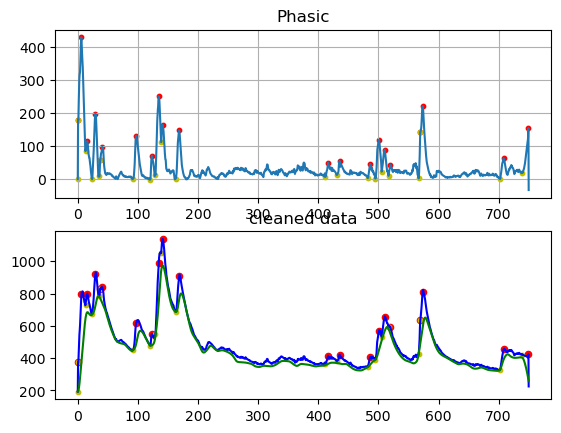

[   11    94   251   467   598   650  1552  1974  2153  2257  2696  6660
  6968  7782  8017  8168  8320  9115  9176 11334 11990]
[    0    14   206   382   575   600  1472  1921  2067  2220  2601  6587
  6897  7718  7920  8086  8270  9069  9118 11239 11834]


array([   11,    94,   251,   467,   598,   650,  1552,  1974,  2153,
        2257,  2696,  6660,  6968,  7782,  8017,  8168,  8320,  9115,
        9176, 11334, 11990], dtype=int64)

In [40]:
Fs = 10    
x =  Get_dataFromTextFile('Sloving_DFS_Alogorthm.txt') 

clean_sig , ph , ton , onsets , ppk , raise_time = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime(  np.array(x) , 0.1 )

print(ppk)
print(onsets)
ppk

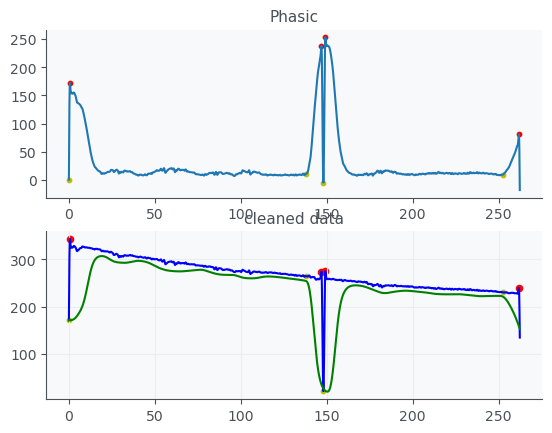

[  10 2351 2389 4190]
[   0 2210 2370 4040]


array([  10, 2351, 2389, 4190], dtype=int64)

In [44]:
Fs = 10    
x =  Get_dataFromTextFile('Wanting_to_sleep.txt') 

clean_sig , ph , ton , onsets , ppk , raise_time = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime(  np.array(x) , 0.1 )

print(ppk)
print(onsets)
ppk